## Text Similarity Search
#### In this Jupyter Notebook, we will evaluate 3 similarity search methods, Cosine Similarity, Euclidean Distance, and Jaccard Similarity on text datasets

In [1]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt


c:\Users\Jun Sheng\OneDrive\Desktop\SC4020-Project-1\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
file_path = "data/text_data/STSbenchmark.xlsx"
df = pd.read_excel(file_path)
df.head()

,sentence1,sentence2,score,similarity
0,A man with a hard hat is dancing.,A man wearing a hard hat is dancing.,5.00,1
1,A young child is riding a horse.,A child is riding a horse.,4.75,1
2,A man is feeding a mouse to a snake.,The man is feeding a mouse to the snake.,5.00,1
3,A woman is playing the guitar.,A man is playing guitar.,2.40,0
4,A woman is playing the flute.,A man is playing a flute.,2.75,0


In [3]:
# Load a pre-trained SentenceTransformer model
model = SentenceTransformer('all-MiniLM-L6-v2') 

# Preprocess the dataframe to ensure sentences are strings
df['sentence1'] = df['sentence1'].apply(lambda x: str(x) if isinstance(x, str) else "")
df['sentence2'] = df['sentence2'].apply(lambda x: str(x) if isinstance(x, str) else "")

sentence1_embeddings = []
sentence2_embeddings = []

# Iterate through each row in the dataframe to compute embeddings
for index, row in df.iterrows():

    sentence1 = row['sentence1']
    sentence2 = row['sentence2']

    # Encode the sentences to get their embeddings
    sentence1_embedding = model.encode([sentence1], normalize_embeddings=True)
    sentence2_embedding = model.encode([sentence2], normalize_embeddings=True)

    # Append embeddings to lists
    sentence1_embeddings.append(sentence1_embedding[0])
    sentence2_embeddings.append(sentence2_embedding[0])


In [4]:
def save_results(similarity_column):

    df_similarity = df[['sentence1', 'sentence2', 'similarity', similarity_column]]

    # Filter rows where 'similarity' and 'method_similarity' do not match
    false_positives = df_similarity[(df_similarity['similarity'] == 0) & (df_similarity[similarity_column] == 1)]
    false_negatives = df_similarity[(df_similarity['similarity'] == 1) & (df_similarity[similarity_column] == 0)]

    # Filter rows where 'similarity' and 'method_similarity' match
    true_positives = df_similarity[(df_similarity['similarity'] == 1) & (df_similarity[similarity_column] == 1)]
    true_negatives = df_similarity[(df_similarity['similarity'] == 0) & (df_similarity[similarity_column] == 0)]

    # Combine both false positives and false negatives
    false_cases = pd.concat([false_positives, false_negatives])

    # Combine both true positives and true negatives
    true_cases = pd.concat([true_positives, true_negatives])

    # Save the results to a CSV file
    false_cases.to_csv(f"results/text_results/{similarity_column}_false_cases.csv", index=False)
    true_cases.to_csv(f"results/text_results/{similarity_column}_true_cases.csv", index=False)

    print(f"Saved results to results/text_results/{similarity_column}_false_cases.csv")
    print(f"Saved results to results/text_results/{similarity_column}_true_cases.csv")


## Cosine Similarity

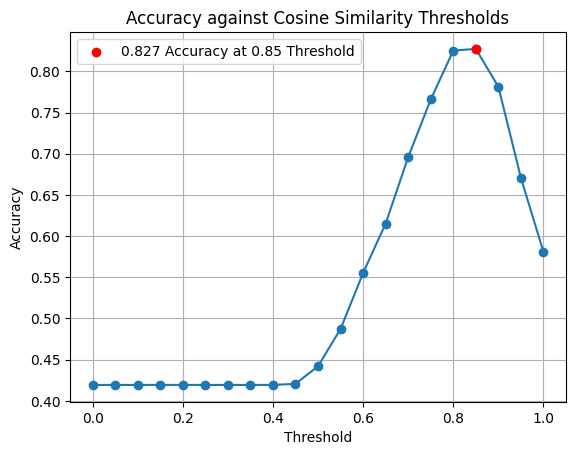

In [5]:
# Lists to store accuracy for each threshold
thresholds = []
accuracies = []

# Loop through thresholds from 0 to 1 with an increment of 0.05
for threshold in [i / 100 for i in range(0, 105, 5)]:

    # Compute cosine similarities for each pair of embeddings
    cosine_score = cosine_similarity(sentence1_embeddings, sentence2_embeddings)
    cosine_score = (cosine_score + 1) / 2 # Normalize similarity scores to range [0, 1]

    # Loop through the DataFrame rows to populate the 'cosine_similarity' column
    for index in range(len(df)):
        if cosine_score[index][index] > threshold:
            df.at[index, 'cosine_similarity'] = 1
        else:
            df.at[index, 'cosine_similarity'] = 0

    cm = confusion_matrix(df['similarity'], df['cosine_similarity'])

    TP = cm[1, 1]  # True Positive
    TN = cm[0, 0]  # True Negative
    FP = cm[0, 1]  # False Positive
    FN = cm[1, 0]  # False Negative

    # Calculate Accuracy
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    accuracies.append(accuracy)
    thresholds.append(threshold)

# Find the threshold with the highest accuracy
max_accuracy = max(accuracies)
max_accuracy_index = accuracies.index(max_accuracy)
best_threshold = thresholds[max_accuracy_index]

# Plotting the accuracy for different thresholds
plt.plot(thresholds, accuracies, marker='o')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.title('Accuracy against Cosine Similarity Thresholds')
plt.grid(True)
plt.scatter(best_threshold, max_accuracy, color='red', zorder=5, label=f'{max_accuracy:.3f} Accuracy at {best_threshold:.2f} Threshold')
plt.legend()
plt.show()

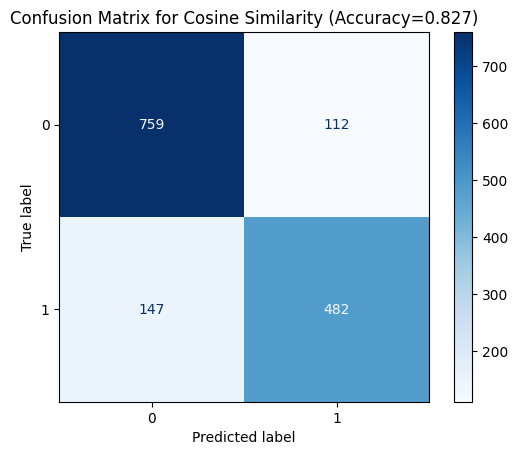

Saved results to results/text_results/cosine_similarity_false_cases.csv
Saved results to results/text_results/cosine_similarity_true_cases.csv


In [6]:
threshold = 0.85

# Loop through the DataFrame rows to populate the 'cosine_similarity' column
for index in range(len(df)): 

    df.at[index, 'cosine_score'] = cosine_score[index][index]

    if cosine_score[index][index] > threshold: 
        df.at[index, 'cosine_similarity'] = 1 
    else:
        df.at[index, 'cosine_similarity'] = 0

cm = confusion_matrix(df['similarity'], df['cosine_similarity'])

TP = cm[1, 1]  # True Positive
TN = cm[0, 0]  # True Negative
FP = cm[0, 1]  # False Positive
FN = cm[1, 0]  # False Negative

# Calculate Accuracy
accuracy = (TP + TN) / (TP + TN + FP + FN)

# Plotting the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['0', '1'])
disp.plot(cmap=plt.cm.Blues)
plt.title(f'Confusion Matrix for Cosine Similarity (Accuracy={accuracy:.3f})')
plt.show()

save_results(similarity_column="cosine_similarity")


## Euclidean Distance

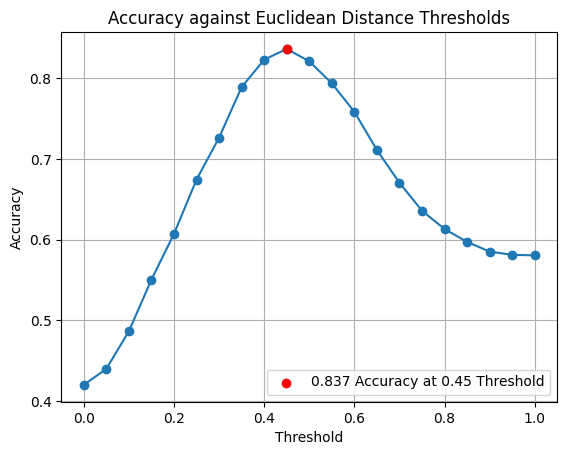

In [7]:
# List to store accuracy for each threshold
thresholds = []
accuracies = []

sentence1_embeddings = np.array(sentence1_embeddings)
sentence2_embeddings = np.array(sentence2_embeddings)

# Loop through thresholds from 0 to 1 with an increment of 0.05
for threshold in [i / 100 for i in range(0, 105, 5)]:

    # Compute Euclidean distance between embeddings
    euclidean_score = np.linalg.norm(sentence1_embeddings - sentence2_embeddings, axis=1)
    euclidean_score = 1 - (euclidean_score - euclidean_score.min()) / (euclidean_score.max() - euclidean_score.min()) # Normalize scores to range [0, 1]

    # Loop through the DataFrame rows to populate the 'euclidean_similarity' column
    for index in range(len(df)): 
        if euclidean_score[index] > threshold: 
            df.at[index, 'euclidean_similarity'] = 1 
        else:
            df.at[index, 'euclidean_similarity'] = 0

    cm = confusion_matrix(df['similarity'], df['euclidean_similarity'])

    TP = cm[1, 1]  # True Positive
    TN = cm[0, 0]  # True Negative
    FP = cm[0, 1]  # False Positive
    FN = cm[1, 0]  # False Negative

    # Calculate Accuracy
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    accuracies.append(accuracy)
    thresholds.append(threshold)

# Find the threshold with the highest accuracy
max_accuracy = max(accuracies)
max_accuracy_index = accuracies.index(max_accuracy)
best_threshold = thresholds[max_accuracy_index]

# Plotting the accuracy for different thresholds
plt.plot(thresholds, accuracies, marker='o')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.title('Accuracy against Euclidean Distance Thresholds')
plt.grid(True)
plt.scatter(best_threshold, max_accuracy, color='red', zorder=5, label=f'{max_accuracy:.3f} Accuracy at {best_threshold:.2f} Threshold')
plt.legend()
plt.show()

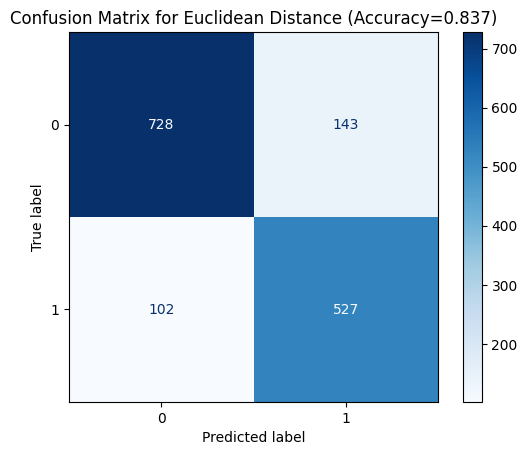

Saved results to results/text_results/euclidean_similarity_false_cases.csv
Saved results to results/text_results/euclidean_similarity_true_cases.csv


In [8]:
threshold = 0.45

# Loop through the DataFrame rows to populate the 'euclidean_similarity' column
for index in range(len(df)): 

    df.at[index, 'euclidean_score'] = euclidean_score[index]

    if euclidean_score[index] > threshold: 
        df.at[index, 'euclidean_similarity'] = 1 
    else:
        df.at[index, 'euclidean_similarity'] = 0

cm = confusion_matrix(df['similarity'], df['euclidean_similarity'])

TP = cm[1, 1]  # True Positive
TN = cm[0, 0]  # True Negative
FP = cm[0, 1]  # False Positive
FN = cm[1, 0]  # False Negative

# Calculate Accuracy
accuracy = (TP + TN) / (TP + TN + FP + FN)

# Plotting the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['0', '1'])
disp.plot(cmap=plt.cm.Blues)
plt.title(f'Confusion Matrix for Euclidean Distance (Accuracy={accuracy:.3f})')
plt.show()

save_results(similarity_column="euclidean_similarity")

## Jaccard Similarity

0.125


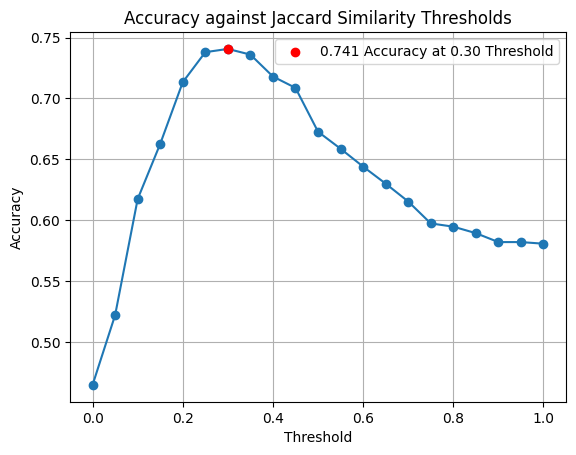

In [9]:
# List to store accuracy for each threshold
thresholds = []
accuracies = []

# Loop through thresholds from 0 to 1 with an increment of 0.05
for threshold in [i / 100 for i in range(0, 105, 5)]:
    
    # Loop through each row in the dataframe to compute Jaccard similarity
    for index, row in df.iterrows():

        sentence1 = row['sentence1']
        sentence2 = row['sentence2']

        # Convert sentences to sets of words
        set1 = set(sentence1.lower().split())
        set2 = set(sentence2.lower().split())

        # Compute Jaccard similarity
        jaccard_score = len(set1.intersection(set2)) / len(set1.union(set2))

        # Populate the 'jaccard_similarity' column based on the threshold
        if jaccard_score > threshold:
            df.at[index, 'jaccard_similarity'] = 1
        else:
            df.at[index, 'jaccard_similarity'] = 0

    cm = confusion_matrix(df['similarity'], df['jaccard_similarity'])

    TP = cm[1, 1]  # True Positive
    TN = cm[0, 0]  # True Negative
    FP = cm[0, 1]  # False Positive
    FN = cm[1, 0]  # False Negative

    # Calculate Accuracy
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    accuracies.append(accuracy)
    thresholds.append(threshold)

print(jaccard_score)

# Find the threshold with the highest accuracy
max_accuracy = max(accuracies)
max_accuracy_index = accuracies.index(max_accuracy)
best_threshold = thresholds[max_accuracy_index]

# Plotting the accuracy for different thresholds
plt.plot(thresholds, accuracies, marker='o')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.title('Accuracy against Jaccard Similarity Thresholds')
plt.grid(True)
plt.scatter(best_threshold, max_accuracy, color='red', zorder=5, label=f'{max_accuracy:.3f} Accuracy at {best_threshold:.2f} Threshold')
plt.legend()
plt.show()

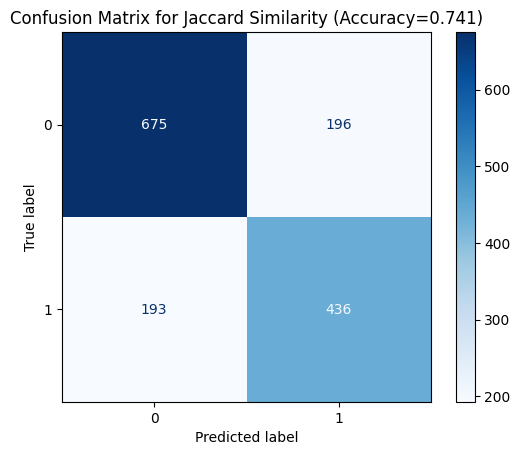

Saved results to results/text_results/jaccard_similarity_false_cases.csv
Saved results to results/text_results/jaccard_similarity_true_cases.csv


In [10]:
threshold = 0.3

# Compute Jaccard similarity
for index, row in df.iterrows():

    sentence1 = row['sentence1']
    sentence2 = row['sentence2']

    # Convert sentences to sets of words
    set1 = set(sentence1.lower().split())
    set2 = set(sentence2.lower().split())

    # Compute Jaccard similarity
    jaccard_score = len(set1.intersection(set2)) / len(set1.union(set2))

    df.at[index, 'jaccard_score'] = jaccard_score
    
    # Populate the 'jaccard_similarity' column based on the threshold
    if jaccard_score > threshold:
        df.at[index, 'jaccard_similarity'] = 1
    else:
        df.at[index, 'jaccard_similarity'] = 0

cm = confusion_matrix(df['similarity'], df['jaccard_similarity'])

TP = cm[1, 1]  # True Positive
TN = cm[0, 0]  # True Negative
FP = cm[0, 1]  # False Positive
FN = cm[1, 0]  # False Negative

# Calculate Accuracy
accuracy = (TP + TN) / (TP + TN + FP + FN)

# Plotting the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['0', '1'])
disp.plot(cmap=plt.cm.Blues)
plt.title(f'Confusion Matrix for Jaccard Similarity (Accuracy={accuracy:.3f})')
plt.show()

save_results(similarity_column="jaccard_similarity")


In [11]:
# Save results to an Excel file
df.to_excel("results/text_results/STSbenchmark_similarities.xlsx", index=False)
df.head()

,sentence1,sentence2,score,similarity,cosine_similarity,cosine_score,euclidean_similarity,euclidean_score,jaccard_similarity,jaccard_score
0,A man with a hard hat is dancing.,A man wearing a hard hat is dancing.,5.00,1,1.0,0.996686,1.0,0.922899,1.0,0.750000
1,A young child is riding a horse.,A child is riding a horse.,4.75,1,1.0,0.976981,1.0,0.796805,1.0,0.833333
2,A man is feeding a mouse to a snake.,The man is feeding a mouse to the snake.,5.00,1,1.0,0.990051,1.0,0.866413,1.0,0.875000
3,A woman is playing the guitar.,A man is playing guitar.,2.40,0,0.0,0.823542,0.0,0.437410,1.0,0.571429
4,A woman is playing the flute.,A man is playing a flute.,2.75,0,1.0,0.873114,1.0,0.522934,1.0,0.571429


## Pearson

In [12]:
def jaccard_similarity(sentence1, sentence2):
    set1 = set(sentence1.lower().split())
    set2 = set(sentence2.lower().split())
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union if union != 0 else 0

In [13]:
# Lists to store similarity scores
cosine_scores = []
jaccard_scores = []
euclidean_dist = []

# Iterate through each row in the dataframe to compute embeddings and similarities
total_pairs = len(df)
for i, (s1, s2) in enumerate(zip(df['sentence1'], df['sentence2']), start=1):
    
    emb1 = model.encode([s1], normalize_embeddings=True)
    emb2 = model.encode([s2], normalize_embeddings=True)

    sim_cos = cosine_similarity(emb1, emb2)[0][0]
    cosine_scores.append(sim_cos)

    # Compute Jaccard similarity
    sim_jaccard = jaccard_similarity(s1, s2)
    jaccard_scores.append(sim_jaccard)

    # Compute Euclidean distance and its similarity
    dist_euc = euclidean_distances(emb1, emb2)[0][0]
    euclidean_dist.append(dist_euc)

    # Print progress every 100 iterations or at the end
    if i % 100 == 0 or i == total_pairs:
        print(f"Processed {i}/{total_pairs} sentence pairs")


min_dist = np.min(euclidean_dist)
max_dist = np.max(euclidean_dist)

euclidean_scores = [1 - (d - min_dist) / (max_dist - min_dist) for d in euclidean_dist]
cosine_scores_norm = [(s + 1) / 2 for s in cosine_scores]

# Add scores to the dataframe
df['cosine_score'] = cosine_scores_norm
df['cosine_score_scaled'] = df['cosine_score'] * 5  # Scale to match gold score scale 

df['jaccard_score'] = jaccard_scores
df['jaccard_score_scaled'] = df['jaccard_score'] * 5

df['euclidean_score'] = euclidean_scores
df['euclidean_score_scaled'] = df['euclidean_score'] * 5

# Prepare arrays
gold_scores = df['score'].values
pred_cosine = df['cosine_score_scaled'].values
pred_jaccard = df['jaccard_score_scaled'].values
pred_euclidean = df['euclidean_score_scaled'].values

# Compute correlations
pearson_cosine, _ = pearsonr(gold_scores, pred_cosine)
spearman_cosine, _ = spearmanr(gold_scores, pred_cosine)

pearson_jaccard, _ = pearsonr(gold_scores, pred_jaccard)
spearman_jaccard, _ = spearmanr(gold_scores, pred_jaccard)

pearson_euc, _ = pearsonr(gold_scores, pred_euclidean)
spearman_euc, _ = spearmanr(gold_scores, pred_euclidean)

# Print results
print("\nCorrelation Results")
print(f"Cosine Similarity - Pearson: {pearson_cosine:.4f} | Spearman: {spearman_cosine:.4f}")
print(f"Jaccard Similarity - Pearson: {pearson_jaccard:.4f} | Spearman: {spearman_jaccard:.4f}")
print(f"Euclidean Distance - Pearson: {pearson_euc:.4f} | Spearman: {spearman_euc:.4f}")


Processed 100/1500 sentence pairs
Processed 200/1500 sentence pairs
Processed 300/1500 sentence pairs
Processed 400/1500 sentence pairs
Processed 500/1500 sentence pairs
Processed 600/1500 sentence pairs
Processed 700/1500 sentence pairs
Processed 800/1500 sentence pairs
Processed 900/1500 sentence pairs
Processed 1000/1500 sentence pairs
Processed 1100/1500 sentence pairs
Processed 1200/1500 sentence pairs
Processed 1300/1500 sentence pairs
Processed 1400/1500 sentence pairs
Processed 1500/1500 sentence pairs

Correlation Results
Cosine Similarity - Pearson: 0.8697 | Spearman: 0.8673
Jaccard Similarity - Pearson: 0.5960 | Spearman: 0.6017
Euclidean Distance - Pearson: 0.8679 | Spearman: 0.8673
